In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from model_diagnostics import model_diagnostics, skf_preds, model_diagnostics_skf, summarise_continuous_feature

#pd.set_option("display.max_rows", 20)

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

data_full = fetch_openml(
    "titanic", version=1, as_frame=True
)

data = pd.concat([data_full['data'], data_full['target']], axis = 1)

drop_cols = ['boat', 'body', 'home.dest']

data.drop(columns = drop_cols, inplace = True)

# change data types to match the csv data types in kaggle
data = data.astype({'pclass': 'int32', 'sex': 'object', 'sibsp': 'int32', 'parch': 'int32', 'fare': 'float32', 'embarked': 'object', 'survived': 'int32'})
data = data.sample(frac = 1)
data.head()

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
895,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,None,S,1
874,3,"Hyman, Mr. Abraham",male,NaN,0,0,3470,7.8875,None,S,1
1149,3,"Riordan, Miss. Johanna 'Hannah'",female,NaN,0,0,334915,7.7208,None,Q,1
1092,3,"Oreskovic, Mr. Luka",male,20.0,0,0,315094,8.6625,None,S,0
1288,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,None,S,0


# Feature Engineering

In [3]:
def feature_engineering(df):
    # construct cabin and deck features
    df['deck_raw'] = df['cabin'].str[0]
    df['deck_raw'] = df['deck_raw'].fillna('M')
    df['cabin_no'] = df['cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int)

    df['deck'] = df['deck_raw'].replace(['A', 'T'], 'A')
    df['deck'] = df['deck'].replace(['F', 'G'], 'FG')

    #construct title features, combine titles
    df['title'] = df['name'].str.split(",", expand = True)[1].str.split('.', expand = True)[0].str.strip()

    df['title'] = df['title'].replace(['Ms'], 'Miss')
    noble_list = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']

    df['title'] = df['title'].replace(noble_list, 'Noble')

    
    df['married'] = 0
    df.loc[df['title'] == 'Mrs', 'married'] = 1

    return(df)


data = feature_engineering(data)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 895 to 598
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int32  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int32  
 5   parch     1309 non-null   int32  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float32
 8   cabin     295 non-null    object 
 9   embarked  1307 non-null   object 
 10  survived  1309 non-null   int32  
 11  deck_raw  1309 non-null   object 
 12  cabin_no  1309 non-null   int64  
 13  deck      1309 non-null   object 
 14  title     1309 non-null   object 
 15  married   1309 non-null   int64  
dtypes: float32(1), float64(1), int32(4), int64(2), object(8)
memory usage: 148.3+ KB


## Deck survival

In [4]:
(
    data
    .assign(deck = data['cabin'].str[0].fillna('M'),
            cabin_no = data['cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int))
    .head(1)
)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived,deck_raw,cabin_no,deck,title,married
895,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,None,S,1,M,0,M,Miss,0


In [5]:
survival_deck = (
    data
    .groupby('deck_raw')
    .agg(n = ('sibsp', 'count'),
         pct_survived = ('survived', 'mean'))
    .reset_index()
)

survival_deck

,deck_raw,n,pct_survived
0,A,22,0.500000
1,B,65,0.723077
2,C,94,0.606383
3,D,46,0.695652
4,E,41,0.731707
5,F,21,0.619048
6,G,5,0.600000
7,M,1014,0.302761
8,T,1,0.000000


In [6]:
#df_all['deck'] = df_all['deck'].replace(['A', 'B', 'C'], 'ABC')
data['deck'].value_counts()

M     1014
C       94
B       65
D       46
E       41
FG      26
A       23
Name: deck, dtype: int64

## Extract Title feature

In [7]:
data['title'].value_counts()

Mr        757
Miss      262
Mrs       197
Master     61
Noble      31
Dona        1
Name: title, dtype: int64

In [8]:
data.query('name.str.contains("Mme")', engine = "python")

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived,deck_raw,cabin_no,deck,title,married
12,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.300003,B35,C,1,B,35,B,Noble,0


In [9]:


data['title'].value_counts()

Mr        757
Miss      262
Mrs       197
Master     61
Noble      31
Dona        1
Name: title, dtype: int64

In [10]:
survival_title = (
    data
    .groupby('title')
    .agg(n = ('name', 'count'),
         avg_survival = ('survived', 'mean'))
    .reset_index()
)

survival_title

,title,n,avg_survival
0,Dona,1,1.000000
1,Master,61,0.508197
2,Miss,262,0.675573
3,Mr,757,0.162483
4,Mrs,197,0.786802
5,Noble,31,0.419355


# Baseline model, simple logistic regression

# Train a model on full training data

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
import xgboost as xgb
from sklearn import set_config

# Initial setup for classification, setting up train/test splits etc
set_config(transform_output="pandas")

target = 'survived'
numeric_cols = ['sibsp', 'parch', 'fare', 'age']
categorical_cols = ['pclass', 'sex', 'embarked', 'deck', 'title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 20230507)

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)

# Pipeline steps for preprocessing data (encode categoricals, impute nulls, discretize / scale numerics) 

ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

# option 1, discretize the data
ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), ['pass_through_numerics__age']),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), ['pass_through_numerics__fare']),
                    ],
    remainder = 'passthrough'
)

# option 2, use a standard scaler
ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), ['pass_through_numerics__age', 'pass_through_numerics__fare'])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('scale', ct_scale),
    ('imputer', IterativeImputer()),
#    ('disc', ct_disc),
    ('clf', xgb_model),
])

pipe.fit(X_train_full, y_train_full)

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Pipeline(steps=[('encode_cats',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['pclass', 'sex', 'embarked',
                                                   'deck', 'title']),
                                                 ('pass_through_numerics',
                                                  'passthrough',
                                                  ['sibsp', 'parch', 'fare',
                                                   'age'])])),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['pass_t...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [15]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       205
           1       0.76      0.75      0.75       123

    accuracy                           0.82       328
   macro avg       0.81      0.80      0.80       328
weighted avg       0.82      0.82      0.82       328



In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_proba[:,1])

0.8574063057703749

# Hyperparameter Optimization

In [33]:
%%time 

from sklearn.model_selection import GridSearchCV

param = {
    'clf__learning_rate': [.1]
    , 'clf__subsample': [.2,.4, .5]
    , 'clf__n_estimators': [25, 50]
    , 'clf__min_child_weight': [25]
    , 'clf__reg_alpha': [.3, .4, .5]
    , 'clf__reg_lambda': [.1, .2, .3, .4, .5]
    , 'clf__colsample_bytree': [.66]
    , 'clf__max_depth': [5, 7, 10]
}

#iter - 4x2x3x5 = 120
gridsearch = GridSearchCV(pipe, param_grid=param, cv=skf, n_jobs=1, scoring='accuracy', return_train_score=True)
gridsearch.fit(X_train_full, y_train_full)
print('best score of Grid Search over 120 iterations:', gridsearch.best_score_)

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250

best score of Grid Search over 120 iterations: 0.7880127808699238
CPU times: user 32min 6s, sys: 9min 57s, total: 42min 4s
Wall time: 7min 24s


/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [20]:
pipe['clf']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [34]:
print("Best parameter (CV score=%0.3f):" % gridsearch.best_score_)
print(gridsearch.best_params_)

Best parameter (CV score=0.788):
{'clf__colsample_bytree': 0.66, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__min_child_weight': 25, 'clf__n_estimators': 50, 'clf__reg_alpha': 0.3, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.4}


# Feature importances

### How do we get feature names?

In [ ]:
pipe.feature_names_in_
pipe.named_steps['encode_cats'].get_feature_names_out()
pipe.named_steps['imputer'].feature_names_in_

### Base XGBoost feature importance 1

In [ ]:
dict_importances = {
    'name': pipe.named_steps['imputer'].get_feature_names_out(),
    #this gets the gain importance get_fscore returns weight type
    'importance': pipe.named_steps['clf'].feature_importances_
}

df_importances = pd.DataFrame(dict_importances)

print(df_importances.sort_values('importance', ascending=False).head())

### Base XGBoost feature importance 2

Explanation: The train() API's method get_score() is defined as:

`get_score(fmap='', importance_type='weight')`

fmap (str (optional)) – The name of feature map file.
importance_type
1. ‘weight’ - the number of times a feature is used to split the data across all trees.
1. ‘gain’ - the average gain across all splits the feature is used in.
1. ‘cover’ - the average coverage across all splits the feature is used in.
1. ‘total_gain’ - the total gain across all splits the feature is used in.
1. ‘total_cover’ - the total coverage across all splits the feature is used in.

In [ ]:
feature_important = pipe.named_steps['clf'].get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_importance.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
feature_important

### Permutation based importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

In [24]:
def run_pipeline(pipeline, input, steps):
    """Run an sklearn pipeline down named steps. Returns the output dataframe

    Args:
        pipeline (sklearn pipeline): The pipeline you want to run
        input (pandas dataframe): The input dataframe
        steps (list[str]): the steps you want to run the pipeline down
    """

    for step in steps:
        output = pipeline[step].transform(input)
        input = output

    return(output)

#run_pipeline(pipe, X_test, ['encode_cats', 'scale', 'imputer'])


Text(0.5, 0, 'Permutation Importance')

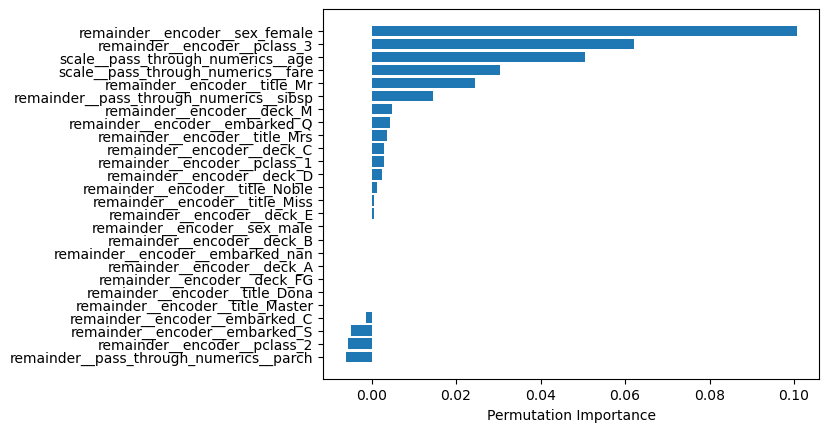

In [25]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

X_preprocessed = run_pipeline(pipe, X_test, ['encode_cats', 'scale', 'imputer'])
perm_importance = permutation_importance(pipe['clf'], X_preprocessed, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_preprocessed.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Shapley value based importance

In [ ]:
import shap

explainer = shap.TreeExplainer(pipe['clf'])
shap_values = explainer.shap_values(X_preprocessed)
shap.summary_plot(shap_values, input, plot_type="bar")

# Appendix: Annoying times working with sklearn OneHotEncoder

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# X = X[['Sex', 'Pclass', 'Embarked']].copy()
# enc.fit_transform(X).toarray()

In [ ]:
# enc.get_feature_names_out()

In [ ]:
# cat_features = ['Pclass', 'Sex', 'Embarked']
# encoded_features = []
# dfs = [X]

# for df in dfs:
#     for feature in cat_features:
#         encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
#         n = df[feature].nunique()
#         cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
#         encoded_df = pd.XFrame(encoded_feat, columns=cols)
#         encoded_df.index = df.index
#         encoded_features.append(encoded_df)


In [ ]:
# cols 

In [ ]:
# encoded_feat